# Longitudinal QuasiCopula GWAS with Mixed Marginals

Here we will use autodiff to compute all gradient/Hessian terms (e.g. Q, W, R) and see if that gives good p-values. 

In [1]:
using Revise
using DataFrames, Random, GLM, QuasiCopula
using ForwardDiff, Test, LinearAlgebra
using LinearAlgebra: BlasReal, copytri!
using ToeplitzMatrices
using BenchmarkTools
using SnpArrays
using MendelPlots
gr(fmt=:png)

BLAS.set_num_threads(1)
Threads.nthreads()

function simulate_random_snparray(s::Union{String, UndefInitializer}, n::Int64,
    p::Int64; mafs::Vector{Float64}=zeros(Float64, p), min_ma::Int = 5)

    #first simulate a random {0, 1, 2} matrix with each SNP drawn from Binomial(2, r[i])
    A1 = BitArray(undef, n, p) 
    A2 = BitArray(undef, n, p) 
    for j in 1:p
        minor_alleles = 0
        maf = 0
        while minor_alleles <= min_ma
            maf = 0.5rand()
            for i in 1:n
                A1[i, j] = rand(Bernoulli(maf))
                A2[i, j] = rand(Bernoulli(maf))
            end
            minor_alleles = sum(view(A1, :, j)) + sum(view(A2, :, j))
        end
        mafs[j] = maf
    end

    #fill the SnpArray with the corresponding x_tmp entry
    return _make_snparray(s, A1, A2)
end

function _make_snparray(s::Union{String, UndefInitializer}, A1::BitArray, A2::BitArray)
    n, p = size(A1)
    x = SnpArray(s, n, p)
    for i in 1:(n*p)
        c = A1[i] + A2[i]
        if c == 0
            x[i] = 0x00
        elseif c == 1
            x[i] = 0x02
        elseif c == 2
            x[i] = 0x03
        else
            throw(MissingException("matrix shouldn't have missing values!"))
        end
    end
    return x
end


┌ Info: Precompiling DataFrames [a93c6f00-e57d-5684-b7b6-d8193f3e46c0]
└ @ Base loading.jl:1423
┌ Info: Precompiling GLM [38e38edf-8417-5370-95a0-9cbb8c7f171a]
└ @ Base loading.jl:1423
┌ Info: Precompiling QuasiCopula [c47b6ae2-b804-4668-9957-eb588c99ffbc]
└ @ Base loading.jl:1423
┌ Info: Precompiling MendelPlots [7ab2ea78-72dd-4c03-85d8-fc2b0db252af]
└ @ Base loading.jl:1423


_make_snparray (generic function with 1 method)

## Simulate data

In [56]:
function simulate_VC_longitudinal(;
    n = 1000, # sample size
    d = 2, # number of observations per sample
    p = 3, # number of nongenetic covariates, including intercept
    m = 1, # number of variance components
    q = 1000, # number of SNPs
    k = 10, # number of causal SNPs
    seed = 2022,
    y_distribution = Bernoulli,
    T = Float64,
    )
    m == 1 || m == 2 || error("m (number of VC) must be 1 or 2")
    
    # non-genetic effect sizes
    Random.seed!(seed)
    βtrue = rand(Uniform(-0.1, 0.1), p)
#     βtrue = [1.0; rand(-0.02:0.04:0.02, p-1)]
    dist = y_distribution()
    link = canonicallink(dist)
    Dist = typeof(dist)
    Link = typeof(link)

    # variance components
    θtrue = fill(0.1, m)
    V1 = ones(d, d)
    V2 = Matrix(I, d, d)
    Γ = m == 1 ? θtrue[1] * V1 : θtrue[1] * V1 + θtrue[2] * V2

    # simulate design matrices
    Random.seed!(seed)
    X_full = [hcat(ones(d), randn(d, p - 1)) for i in 1:n]

    # simulate random SnpArray with q SNPs and randomly choose k SNPs to be causal
    Random.seed!(2022)
    G = simulate_random_snparray(undef, n, q)
    Gfloat = convert(Matrix{T}, G, center=true, scale=false)
    γtrue = zeros(q)
    γtrue[1:k] .= rand([-0.2, 0.2], k)
    shuffle!(γtrue)
    η_G = Gfloat * γtrue

    # simulate phenotypes
    if y_distribution == Normal
        τtrue = 10.0
        σ2 = inv(τtrue)
        σ = sqrt(σ2)
        obs = Vector{GaussianCopulaVCObs{T}}(undef, n)
        for i in 1:n
            X = X_full[i]
            η = X * βtrue
            η .+= η_G[i] # add genetic effects
            μ = GLM.linkinv.(link, η)
            vecd = Vector{ContinuousUnivariateDistribution}(undef, d)
            for i in 1:d
                vecd[i] = y_distribution(μ[i], σ)
            end
            nonmixed_multivariate_dist = NonMixedMultivariateDistribution(vecd, Γ)
            # simuate single vector y
            y = Vector{T}(undef, d)
            res = Vector{T}(undef, d)
            rand(nonmixed_multivariate_dist, y, res)
            V = m == 1 ? [V1] : [V1, V2]
            obs[i] = GaussianCopulaVCObs(y, X, V)
        end
        qc_model = GaussianCopulaVCModel(obs)
    else
        obs = Vector{GLMCopulaVCObs{T, Dist, Link}}(undef, n)
        for i in 1:n
            X = X_full[i]
            η = X * βtrue
            η .+= η_G[i] # add genetic effects
            μ = GLM.linkinv.(link, η)
            vecd = Vector{DiscreteUnivariateDistribution}(undef, d)
            for i in 1:d
                vecd[i] = y_distribution(μ[i])
            end
            nonmixed_multivariate_dist = NonMixedMultivariateDistribution(vecd, Γ)
            # simuate single vector y
            y = Vector{T}(undef, d)
            res = Vector{T}(undef, d)
            rand(nonmixed_multivariate_dist, y, res)
            V = m == 1 ? [V1] : [V1, V2]
            obs[i] = GLMCopulaVCObs(y, X, V, dist, link)
        end
        qc_model = GLMCopulaVCModel(obs)
    end
    return qc_model, Γ, G, βtrue, θtrue, γtrue
end

k = 0 # number of causal SNPs

qc_model, Γ, G, βtrue, θtrue, γtrue = simulate_VC_longitudinal(
    n = 5000, # sample size
    d = 5, # number of observations per sample
    p = 3, # number of fixed effects, including intercept
    m = 2, # number of variance components
    q = 1000, # number of SNPs
    k = k, # number of causal SNPs
    seed = 2022,
    y_distribution = Normal,
    T = Float64,
)

@show qc_model;

qc_model = Quasi-Copula Variance Component Model
  * base distribution: Normal
  * link function: IdentityLink
  * number of clusters: 5000
  * cluster size min, max: 5, 5
  * number of variance components: 2
  * number of fixed effects: 3



## Fit Null model

In [57]:
@time optm = QuasiCopula.fit!(qc_model,
    Ipopt.IpoptSolver(
        print_level = 5, 
        tol = 10^-6, 
        max_iter = 100,
        accept_after_max_steps = 4,
        warm_start_init_point="yes", 
        limited_memory_max_history = 6, # default value
        hessian_approximation = "limited-memory",
#         derivative_test="second-order"
    )
);

This is Ipopt version 3.13.4, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:        6
                     variables with only lower bounds:        3
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

┌ Warning: Optimization unsuccesful; got UserLimit
└ @ QuasiCopula /Users/biona001/.julia/dev/QuasiCopula/src/parameter_estimation/fit_gaussian_vc.jl:36


In [58]:
@show βtrue
@show qc_model.β
@show qc_model.∇β

@show θtrue
@show qc_model.θ
@show qc_model.∇θ;

βtrue = [-0.07862270924112941, 0.0811052878194761, 0.004125250997353946]
qc_model.β = [-0.07942021920981282, 0.0867597854892763, 0.0020328104490122795]
qc_model.∇β = [-46.86163213623711, -169.7612597433075, 168.61212220572057]
θtrue = [0.1, 0.1]
qc_model.θ = [0.07754690208709304, 0.0748236811960934]
qc_model.∇θ = [-19.35295007304929, -70.09846564174487]


# Loglikelihood function friendly to autodiff

In [61]:
function A_mul_b!(c::AbstractVector{T}, A::AbstractMatrix, b::AbstractVector) where T
    n, p = size(A)
    fill!(c, zero(T))
    for j in 1:p, i in 1:n
        c[i] += A[i, j] * b[j]
    end
    return c
end

function loglikelihood(
    par::AbstractVector{T}, # p+2+1 × 1 where 2 is for θ, 1 is for the SNP
    qc_model::Union{GLMCopulaVCModel, NBCopulaVCModel}, # fitted null model
    z::AbstractVector # n × 1 genotype vector
    ) where T
    β = [par[1:end-3]; par[end]] # nongenetic + genetic beta
    θ = par[end-2:end-1]         # vc parameters
    # allocate vector of type T
    n, p = size(qc_model.data[1].X)
    η = zeros(T, n)
    μ = zeros(T, n)
    varμ = zeros(T, n)
    res = zeros(T, n)
    storage_n = zeros(T, n)
    q = zeros(T, length(θ))
    logl = zero(T)
    for (i, gc) in enumerate(qc_model.data)
        snps = fill(z[i], size(gc.X, 1))
        X = hcat(gc.X, snps) # genetic and nongenetic covariates
        y = gc.y
        n, p = size(X)
        # update_res! step (need to avoid BLAS)
        A_mul_b!(η, X, β)
        for j in 1:gc.n
            μ[j] = GLM.linkinv(gc.link, η[j])
            varμ[j] = GLM.glmvar(gc.d, μ[j]) # Note: for negative binomial, d.r is used
#             dμ[j] = GLM.mueta(gc.link, η[j])
#             w1[j] = dμ[j] / varμ[j]
#             w2[j] = w1[j] * dμ[j]
            res[j] = y[j] - μ[j]
        end
        # standardize_res! step
        for j in eachindex(y)
            res[j] /= sqrt(varμ[j])
        end
        # std_res_differential! step (this will compute ∇resβ)
#         for i in 1:gc.p
#             for j in 1:gc.n
#                 ∇resβ[j, i] = -sqrt(varμ[j]) * X[j, i] - (0.5 * res[j] * (1 - (2 * μ[j])) * X[j, i])
#             end
#         end
        # update Γ
        @inbounds for k in 1:gc.m
            A_mul_b!(storage_n, gc.V[k], res)
            q[k] = dot(res, storage_n) / 2 # q[k] = 0.5 r' * V[k] * r (update variable b for variance component model)
        end
        # component_loglikelihood
        for j in 1:gc.n
            logl += QuasiCopula.loglik_obs(gc.d, y[j], μ[j], one(T), one(T))
        end
        tsum = dot(θ, gc.t)
        logl += -log(1 + tsum)
        qsum  = dot(θ, q) # qsum = 0.5 r'Γr
        logl += log(1 + qsum)
    end
    return logl
end

function loglikelihood(
    par::AbstractVector{T}, # p+2+1+1, where 2 is for θ, 1 is τ, and last 1 is for the SNP
    gcm::GaussianCopulaVCModel,
    z::AbstractVector # n × 1 genotype vector
    ) where T
    β = [par[1:end-4]; par[end]] # nongenetic + genetic beta
    θ = par[end-3:end-2]         # vc parameters
    τ = par[end-1]               # dispersion for gaussian
    # allocate vector of type T
    n, p = size(gcm.data[1].X)
    μ = zeros(T, n)
    res = zeros(T, n)
    storage_n = zeros(T, n)
    q = zeros(T, length(θ))
    logl = zero(T)
    for (i, gc) in enumerate(qc_model.data)
        snps = fill(z[i], size(gc.X, 1))
        X = hcat(gc.X, snps) # genetic and nongenetic covariates
        y = gc.y
        n, p = size(X)
        sqrtτ = sqrt(abs(τ))
        # update_res! step (need to avoid BLAS)
        A_mul_b!(μ, X, β)
        for j in 1:gc.n
            res[j] = y[j] - μ[j]
        end
        # standardize_res! step
        res .*= sqrtτ
        rss  = abs2(norm(res)) # RSS of standardized residual
        tsum = dot(abs.(θ), gc.t) # ben: why is there abs here?
        logl += - log(1 + tsum) - (gc.n * log(2π) -  gc.n * log(abs(τ)) + rss) / 2
        # update Γ
        @inbounds for k in 1:gc.m
            A_mul_b!(storage_n, gc.V[k], res)
            q[k] = dot(res, storage_n) / 2 # q[k] = 0.5 r' * V[k] * r (update variable b for variance component model)
        end
        qsum  = dot(θ, q)
        logl += log(1 + qsum)
    end
    return logl
end

autodiff_loglikelihood(β) = loglikelihood(β, qc_model, z)

autodiff_loglikelihood (generic function with 1 method)

First, check if `autodiff_loglikelihood` returns same answer as `QuasiCopula.loglikelihood!`

In [62]:
i = 1
z = convert(Vector{Float64}, @view(G[:, i]), center=true, scale=false)
# fullβ = [qc_model.β; qc_model.θ; 0.0] # poisson or bernoulli
fullβ = [qc_model.β; qc_model.θ; qc_model.τ; 0.0] # normal

@show autodiff_loglikelihood(fullβ)
@show QuasiCopula.loglikelihood!(qc_model, false, false);

autodiff_loglikelihood(fullβ) = -8405.453657798216
QuasiCopula.loglikelihood!(qc_model, false, false) = -8405.45365779823


Lets compute a few Hessians

In [63]:
# autodiff Gradient
∇logl = x -> ForwardDiff.gradient(autodiff_loglikelihood, x)

# autodiff Hessian
∇²logl = x -> ForwardDiff.hessian(autodiff_loglikelihood, x)

#62 (generic function with 1 method)

In [64]:
i = 1
z = convert(Vector{Float64}, @view(G[:, i]), center=true, scale=false)
Hfull = ∇²logl(fullβ) # snp 1

7×7 Matrix{Float64}:
 -180054.0      -372.956          822.02    …    -5.02101    -145.479
    -372.956      -2.20698e5     -298.431       -18.5145      368.945
     822.02     -298.431      -217976.0          15.6225     -306.517
   -1648.77      224.469          271.057       557.419      -279.347
     -51.1885    122.903          -44.562       652.544       -33.0292
      -5.02101   -18.5145          15.6225  …  -142.949         3.24425
    -145.479     368.945         -306.517         3.24425  -18937.7

In [65]:
i = 16
z = convert(Vector{Float64}, @view(G[:, i]), center=true, scale=false)
Hfull = ∇²logl(fullβ) # snp 10

7×7 Matrix{Float64}:
 -180054.0      -372.956      …    -51.1885    -5.02101    -167.252
    -372.956      -2.20698e5       122.903    -18.5145      573.299
     822.02     -298.431           -44.562     15.6225     -979.616
   -1648.77      224.469           -38.2823   557.419       524.862
     -51.1885    122.903         -3478.02     652.544       -47.861
      -5.02101   -18.5145     …    652.544   -142.949       -55.2552
    -167.252     573.299           -47.861    -55.2552   -77792.1

In [66]:
W = -Hfull[1:end-1, end]
Q = -Hfull[end, end]
Pinv = inv(-Hfull[1:end-1, 1:end-1])
R = ∇logl(fullβ)[end]
S = R * inv(Q - W'*Pinv*W) * R
pval = ccdf(Chisq(1), S)

0.09487526723381465

In [67]:
∇logl(fullβ)

7-element Vector{Float64}:
  -46.86163213623448
 -169.7612597433045
  168.61212220571565
  -19.35295007305163
  -70.0984656417475
   13.53933736961438
 -460.56661186277677

# Score tests by autodiffing everything

In [74]:
function GWASCopulaVCModel_autodiff(
    gcm::Union{GLMCopulaVCModel, NBCopulaVCModel},
    G::SnpArray;
    )
    # define autodiff likelihood, gradient, and Hessians
    autodiff_loglikelihood(β) = loglikelihood(β, qc_model, z)
    ∇logl = x -> ForwardDiff.gradient(autodiff_loglikelihood, x)
    ∇²logl = x -> ForwardDiff.hessian(autodiff_loglikelihood, x)
    
    # some needed constants
    n, q = size(G)
    p = length(gcm.β)
    dist = QuasiCopula._get_null_distribution(gcm)
    T = eltype(gcm.data[1].X)
    n == length(gcm.data) || error("sample size do not agree")
    any(x -> abs(x) > 1e-3, gcm.∇β) && error("Null model gradient of beta is not zero!")
    any(x -> abs(x) > 1e-3, gcm.∇θ) && error("Null model gradient of variance components is not zero!")
    # compute P (negative Hessian) and inv(P)
    z = convert(Vector{Float64}, @view(G[:, 1]), center=true, scale=false, impute=false)
    fullβ = [qc_model.β; qc_model.θ; 0.0]
    Hfull = ∇²logl(fullβ)
    Pinv = inv(-Hfull[1:end-1, 1:end-1])
    # score test for each SNP
    pvals = zeros(T, q)
    for j in 1:q
        SnpArrays.copyto!(z, @view(G[:, j]), center=true, scale=false, impute=false)
        Hfull = ∇²logl(fullβ)
        W = -Hfull[1:end-1, end]
        Q = -Hfull[end, end]
        R = ∇logl(fullβ)[end]
        S = R * inv(Q - W'*Pinv*W) * R
        pval = ccdf(Chisq(1), S)
        pvals[j] = pval == 0 ? 1 : pval
    end
    return pvals
end

function GWASCopulaVCModel_autodiff(
    gcm::GaussianCopulaVCModel,
    G::SnpArray;
    )
    # define autodiff likelihood, gradient, and Hessians
    autodiff_loglikelihood(β) = loglikelihood(β, qc_model, z)
    ∇logl = x -> ForwardDiff.gradient(autodiff_loglikelihood, x)
    ∇²logl = x -> ForwardDiff.hessian(autodiff_loglikelihood, x)
    
    # some needed constants
    n, q = size(G)
    p = length(gcm.β)
    dist = QuasiCopula._get_null_distribution(gcm)
    T = eltype(gcm.data[1].X)
    n == length(gcm.data) || error("sample size do not agree")
#     any(x -> abs(x) > 1e-3, gcm.∇β) && error("Null model gradient of beta is not zero!")
#     any(x -> abs(x) > 1e-3, gcm.∇θ) && error("Null model gradient of variance components is not zero!")
    # compute P (negative Hessian) and inv(P)
    z = convert(Vector{Float64}, @view(G[:, 1]), center=true, scale=false, impute=false)
    fullβ = [qc_model.β; qc_model.θ; qc_model.τ; 0.0]
    Hfull = ∇²logl(fullβ)
    Pinv = inv(-Hfull[1:end-1, 1:end-1])
    # score test for each SNP
    pvals = zeros(T, q)
    for j in 1:q
        SnpArrays.copyto!(z, @view(G[:, j]), center=true, scale=false, impute=false)
        Hfull = ∇²logl(fullβ)
        W = -Hfull[1:end-1, end]
        Q = -Hfull[end, end]
        R = ∇logl(fullβ)[end]
        S = R * inv(Q - W'*Pinv*W) * R
        pval = ccdf(Chisq(1), S)
        pvals[j] = pval == 0 ? 1 : pval
    end
    return pvals
end

GWASCopulaVCModel_autodiff (generic function with 3 methods)

In [75]:
@time pvals = GWASCopulaVCModel_autodiff(qc_model, G)

 87.620305 seconds (620.20 M allocations: 105.857 GiB, 13.39% gc time, 4.00% compilation time)


1000-element Vector{Float64}:
 0.8535987743049637
 0.2786513201000327
 0.6707197265626959
 0.8447940478039098
 0.6393854598490942
 0.8472083230414874
 0.010624024375074306
 0.8760846767298205
 0.4295750762157907
 0.3673940582213956
 0.5460142178352267
 0.3872338752614667
 0.894713911724243
 ⋮
 0.28354201473750773
 0.7255064039642294
 0.2764711520670061
 0.18910200106366862
 0.298710199331048
 0.7232274535942902
 0.49886857494758446
 0.9210818514446771
 0.6544663090239784
 0.14097552155773757
 0.13493769003979483
 0.2040146380961452

In [76]:
correct_snps = findall(!iszero, γtrue)
signif_snps = findall(x -> x < 0.05/length(pvals), pvals)
power = length(correct_snps ∩ signif_snps) / max(1, length(correct_snps))

@show length(signif_snps)
@show power

length(signif_snps) = 0
power = 0.0


0.0

In [77]:
# pvalues of truly causal SNPs
pvals[correct_snps] |> sort

Float64[]

In [78]:
# pvalues of all SNPs sorted by significance
sort(pvals)

1000-element Vector{Float64}:
 0.0016811360260544856
 0.006722036530799134
 0.007313548187976993
 0.007831625663756826
 0.008555659905935
 0.009044388104475075
 0.010624024375074306
 0.010788594407152748
 0.010903250319789396
 0.011472104746104717
 0.012021338057018693
 0.012462248465690424
 0.012904716911608995
 ⋮
 0.9878304141654196
 0.9884531939011764
 0.989079729277882
 0.989279161335442
 0.9893884036754402
 0.9898120994560248
 0.9931488229752532
 0.9947580423778025
 0.9949176604062812
 0.9951995816706248
 0.996080410346502
 0.9999097893163056

## QQ Plots

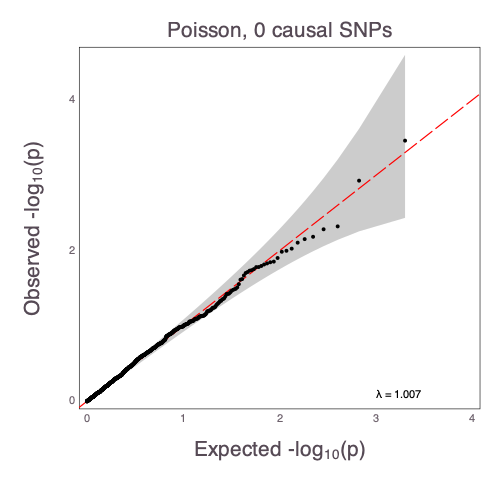

In [22]:
qq(pvals, dpi=100, titles="Poisson, $k causal SNPs")
display("image/png", read("qqplot.png"))

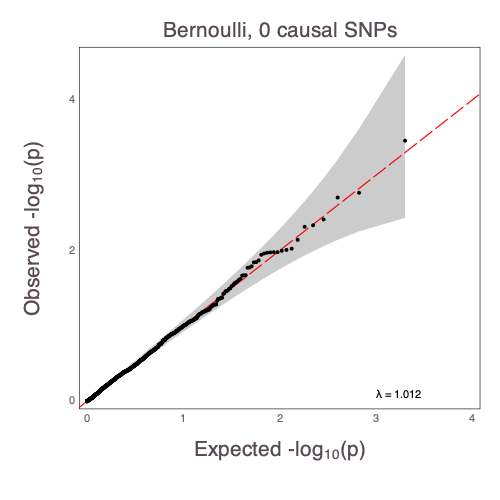

In [38]:
qq(pvals, dpi=100, titles="Bernoulli, $k causal SNPs")
display("image/png", read("qqplot.png"))

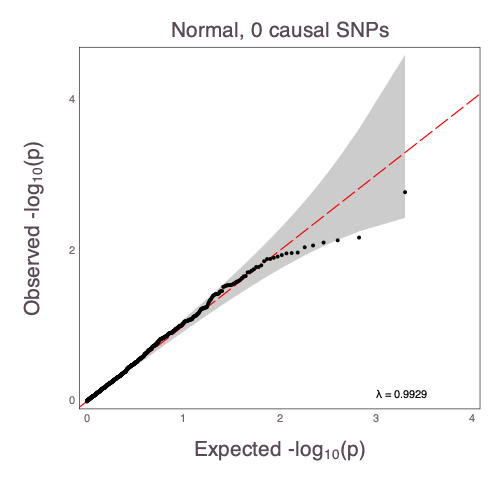

In [79]:
qq(pvals, dpi=100, titles="Normal, $k causal SNPs")
display("image/png", read("qqplot.png"))